### **Heavy Machinery Image Recognition**

We are going to build a Machine Learning which can recognize a heavy machinery images, whether it is a truck or an excavator

In [26]:
from IPython.display import display
import os
import requests
from PIL import Image
from io import BytesIO

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation

from sklearn.svm import SVC

from matplotlib import pyplot as plt

## **Connect to Google Drive**

Our data is stored in Google Drive, so we need to mount/connect our Google Colab session to Google Drive folder

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Define the path of the folder in our Google Drive**

In [28]:
DATA_SOURCE = "/content/gdrive/My Drive/Colab Notebooks/images_data/"
PATH_TRUCK_IMAGES = DATA_SOURCE + "Trucks/"
PATH_EXCAVATOR_IMAGES = DATA_SOURCE + "Excavators/"

## **Let's try to read and image and do Some Processing**

In [29]:
HEIGHT = 200
WIDTH = 300
IMAGE_SIZE = (HEIGHT, WIDTH, 1)

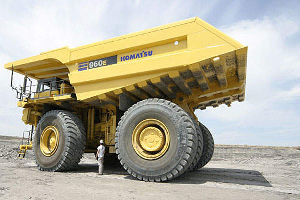

In [30]:
img = load_img(PATH_TRUCK_IMAGES + "6-image-Komatsu-960E-1.jpg", target_size=IMAGE_SIZE)
display(img)

An image is actually just an array. Our photos above is a colored image, or we can call it an RGB image.  

RGB image is a 3D array, which first dimension indicates height, second dimension indicates width, and the third dimension indicates th intensity of color red, green, and blue

In [31]:
img_array = img_to_array(img)
img_array.shape

(200, 300, 3)

**Converting to Grayscale**

In our case, we can clearly see that trucks and excavators have very different shape. Also, most of them are colored yellow (or yellow-ish). Therefore, it is okay to ignore colors and convert our image to grayscale to save some resources.  

Converting RGB image to Grayscale image means we reduce data-size to 1/3, thus saving a lot computing resources

In [32]:
img_array_grayscale = tf.image.rgb_to_grayscale(img_array, name=None)[:,:,0]/255
img_array_grayscale.shape

TensorShape([200, 300])

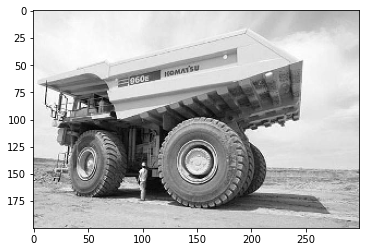

In [33]:
plt.imshow(img_array_grayscale, cmap='gray', vmin=0, vmax=1)
plt.show()

In [34]:
img_array_grayscale_flat = img_array.flatten()
img_array_grayscale_flat.shape

(180000,)

In [35]:
img_array_grayscale_flat

array([228., 235., 245., ..., 200., 197., 182.], dtype=float32)

## **Building The Machine Learning**

## **Load images from directory**

In [36]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATA_SOURCE, 
    class_names=["Excavators", "Trucks"],
    subset="training", validation_split=0.2,
    seed=100,
    label_mode="binary",
    color_mode='grayscale' if IMAGE_SIZE[-1]==1 else "rgb", # <-------------------------------------------- automatically set the image to grayscale
    image_size=IMAGE_SIZE[0:-1],
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATA_SOURCE, 
    class_names=["Excavators", "Trucks"],
    subset="validation", validation_split=0.2,
    seed=100,
    label_mode="binary",
    color_mode='grayscale' if IMAGE_SIZE[-1]==1 else "rgb", # <-------------------------------------------- automatically set the image to grayscale
    image_size=IMAGE_SIZE[0:-1],
)

Found 124 files belonging to 2 classes.
Using 100 files for training.
Found 124 files belonging to 2 classes.
Using 24 files for validation.


## Design our Machine Learning

## 1. Simple Flattened Image + Support Vector Machine (SVM)

In [37]:
simple_ML = tf.keras.Sequential()
simple_ML.add(tf.keras.layers.experimental.preprocessing.Rescaling(1/255, input_shape=IMAGE_SIZE))
simple_ML.add(tf.keras.layers.Flatten())
simple_ML.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
simple_ML.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 200, 300, 1)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 60000)             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [38]:
for images, labels in train_data.take(1): 
    X_train = images.numpy()
    train_labels = labels.numpy()
X_train = simple_ML.predict(X_train)
train_labels = train_labels.flatten()

for images, labels in validation_data.take(1): 
    X_validation = images.numpy()
    validation_labels = labels.numpy()
X_validation = simple_ML.predict(X_validation)
validation_labels = validation_labels.flatten()

SVC_classifier = SVC()
SVC_classifier.fit(X=X_train, y=train_labels)

y_training = SVC_classifier.predict(X_train) 
y_predict = SVC_classifier.predict(X_validation)

accuracy_t = np.sum([y_training == train_labels])/len(train_labels)
accuracy_v = np.sum([y_predict == validation_labels])/len(validation_labels)

print("Accuracy on Training Set: {}".format(accuracy_t))
print("Accuracy on Validation Set: {}".format(accuracy_v))

Accuracy on Training Set: 1.0
Accuracy on Validation Set: 0.7083333333333334


## 2. Convolutional Neural Network (CNN)

In [39]:
CNN_model = tf.keras.Sequential()
CNN_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1/255, input_shape=IMAGE_SIZE))
CNN_model.add(Conv2D(30, (5,5), input_shape=IMAGE_SIZE, activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Conv2D(30, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Dropout(0.2))
CNN_model.add(Flatten())
CNN_model.add(Dense(100, activation='relu'))
CNN_model.add(Dense(20, activation='relu'))
CNN_model.add(Dense(1, activation='sigmoid'))
CNN_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 200, 300, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 296, 30)      780       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 148, 30)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 146, 30)       8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 73, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 73, 30)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 105120)           

In [40]:
training = CNN_model.fit(train_data, validation_data=validation_data, batch_size=80, epochs=10)

Epoch 1/10
4/4 [==============================] - 5s 1s/step - loss: 1.2978 - accuracy: 0.5700 - val_loss: 0.7478 - val_accuracy: 0.4583
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 0.6481 - accuracy: 0.6200 - val_loss: 0.9300 - val_accuracy: 0.5417
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 0.7750 - accuracy: 0.5300 - val_loss: 0.6796 - val_accuracy: 0.6250
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.6160 - accuracy: 0.9600 - val_loss: 0.6789 - val_accuracy: 0.7083
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 0.5634 - accuracy: 0.8100 - val_loss: 0.6595 - val_accuracy: 0.7083
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 0.4910 - accuracy: 0.8600 - val_loss: 0.6114 - val_accuracy: 0.7083
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 0.3542 - accuracy: 0.8800 - val_loss: 0.5967 - val_accuracy: 0.7083
Epoch 8/10
4/4 [=========================

In [41]:
def predict_image(url, model):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img_resize = img.resize((IMAGE_SIZE[1], IMAGE_SIZE[0]))
  img_resize_display = img.resize((IMAGE_SIZE[1], IMAGE_SIZE[0]), Image.ANTIALIAS)

  img_array = tf.keras.preprocessing.image.img_to_array(
      img_resize, data_format=None, dtype=None
  )
  img_array_grayscale = tf.image.rgb_to_grayscale(img_array, name=None).numpy()
  img_array_grayscale.shape

  img_array_grayscale =img_array_grayscale.reshape(1, 200, 300, 1)
  prediction = model.predict(img_array_grayscale)[0][0]
  predict_label = "Excavator" if prediction < 0.5 else "Dump Truck"
  predict_score = 1-prediction if prediction < 0.5 else prediction
  print("{0} (Confidence: {1:.2f}%)".format(predict_label, predict_score*100))
  display(img_resize_display)

Dump Truck (Confidence: 63.62%)


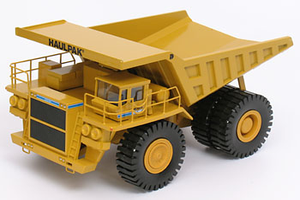

In [42]:
url = "https://baumaschinen-modelle.net/de/sammlung/Dresser_730E.jpg"

predict_image(url=url, model=CNN_model)